In [15]:
!pip install --upgrade install seaborn matplotlib pandas numpy scikit-learn optuna alembic importlib_resources mako tqdm

Looking in links: https://download.pytorch.org/whl/nightly/cu113/torch_nightly.htmL
  Using cached https://files.pythonhosted.org/packages/c0/f2/b12037765c40da46d7a48914dda220187a69d3a6a1ff102330c2e647f9a6/torch-1.10.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/97/b93e7edcdf5f0321bef2c8404ca8e8401e7f1f869ba8ee986f71514ca1b3/matplotlib-3.5.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b2/56/f886ed6f1777ffa9d54c6e80231b69db8a1f52dcc33f5967b06a105dcfe0/pandas-1.3.5-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/22/a3/3a5469ebaca59100e50b4300dd011eed943f2aad7c6a80a07966b985e2c6/numpy-1.21.5-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/9d/20/0ffe8665a44bce7616bd33d4368a198fecad3b226bcafa38c63ef0f62

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\itay\\documents\\github\\cuda-experiments\\venv\\lib\\site-packages\\~-rch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import json
from src.models.gmf import GMF
from src.models.autorec import AutoRec
from src.models.autorec_v2 import AutoRecV2
from src.training import GMFTrainer, AutoRecTrainer
from src.datasets import make_dataloader, GMFRatingDataset, IAutoRecRatingDataset, UAutoRecRatingDataset, make_weighted_dataloader
from src.metrics import GMFEvaluator, IAutoRecEvaluator, UAutoRecEvaluator
from src.hyperparameter_optimization import hyperparameter_tune

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [25]:
ml_df = pd.read_csv('data/ml_1m_preprocessed.csv')
print(ml_df.shape)

am_df = pd.read_csv('data/am_preprocessed.csv')
print(am_df.shape)

(1000209, 3)
(169781, 3)


In [26]:
n_users_ml = ml_df['user_id'].max() + 1
n_items_ml = ml_df['item_id'].max() + 1
print(n_users_ml, n_items_ml)

n_users_am = am_df['user_id'].max() + 1
n_items_am = am_df['item_id'].max() + 1
print(n_users_am, n_items_am)

6040 3706
16566 11797


In [27]:
train_test_seed = 123
train_val_seed = 666

train_val_df_ml, test_df_ml = train_test_split(ml_df, test_size=.1, random_state=train_test_seed)
train_df_ml, validation_df_ml = train_test_split(train_val_df_ml, test_size=.1, random_state=train_val_seed)

train_val_df_am, test_df_am = train_test_split(am_df, test_size=.1, random_state=train_test_seed)
train_df_am, validation_df_am = train_test_split(train_val_df_am, test_size=.1, random_state=train_val_seed)

## UAutoRec

##### HP Optimization - MovieLens

In [6]:
uautorec_ml_hyperparams, uautorec_ml_trials_df = (
    hyperparameter_tune('UAutoRec', {
    'hidden_size': (int, (128, 1024), False),
    'reg_lambda': (float, (1e-4, 1e3), True),
     }, train_val_df_ml, lr=1e-3, n_trials=1, batch_size=128, patience=0, n_epochs=2, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=512)]))

print(uautorec_ml_hyperparams)
with open('hyperparams/uautorec_ml.json', 'w') as f:
    json.dump(uautorec_ml_hyperparams, f, indent=4)

uautorec_ml_trials_df.to_csv('hyperparams/uautorec_ml_trials.csv', index=False)

[I 2022-01-31 12:30:19,588] A new study created in memory with name: no-name-3dacbcd7-b9c6-482f-be28-aec038617d37
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 1/2:   0%|                                                                          | 0/48 [00:00<?, ?it/s]

<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 1/2:  10%|███▉                                  | 5/48 [00:02<00:17,  2.45it/s, Loss=2.04e+7, rmse=6.17928]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 1/2:  31%|███████████▌                         | 15/48 [00:02<00:03,  9.61it/s, Loss=2.37e+7, rmse=4.71504]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 1/2:  52%|███████████████████▎                 | 25/48 [00:03<00:01, 18.33it/s, Loss=2.64e+7, rmse=4.13312]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 1/2:  62%|███████████████████████▏             | 30/48 [00:03<00:00, 22.75it/s, Loss=2.79e+7, rmse=3.72031]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 1/2:  83%|██████████████████████████████▊      | 40/48 [00:03<00:00, 30.09it/s, Loss=2.93e+7, rmse=3.43544]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 1/2: 100%|█████████████████████████████████████| 48/48 [00:03<00:00, 13.01it/s, Loss=3.01e+7, rmse=3.26536]


<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:   0%|                                                   | 0/48 [00:00<?, ?it/s, Loss=8.89e+4, rmse=2.14456]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  10%|████▍                                      | 5/48 [00:00<00:00, 45.03it/s, Loss=4.02e+5, rmse=2.10072]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  21%|████████▉                                  | 10/48 [00:00<00:00, 46.01it/s, Loss=5.4e+5, rmse=2.09535]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  31%|█████████████▏                            | 15/48 [00:00<00:00, 47.03it/s, Loss=8.04e+5, rmse=2.10685]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  42%|█████████████████▌                        | 20/48 [00:00<00:00, 44.99it/s, Loss=8.95e+5, rmse=2.10159]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  52%|█████████████████████▉                    | 25/48 [00:00<00:00, 44.98it/s, Loss=1.22e+6, rmse=2.10546]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  52%|██████████████████████▍                    | 25/48 [00:00<00:00, 44.98it/s, Loss=1.4e+6, rmse=2.10621]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  75%|███████████████████████████████▌          | 36/48 [00:00<00:00, 47.13it/s, Loss=1.64e+6, rmse=2.11149]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  75%|███████████████████████████████▌          | 36/48 [00:00<00:00, 47.13it/s, Loss=1.83e+6, rmse=2.11461]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  85%|███████████████████████████████████▉      | 41/48 [00:00<00:00, 47.56it/s, Loss=2.05e+6, rmse=2.11552]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation: 100%|██████████████████████████████████████████| 48/48 [00:01<00:00, 47.35it/s, Loss=2.16e+6, rmse=2.11192]


<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:   0%|                                               | 0/48 [00:00<?, ?it/s, Loss=3.22e+5, rmse=1.6322]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  10%|████                                   | 5/48 [00:00<00:01, 42.37it/s, Loss=9.42e+5, rmse=1.6268]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  10%|████                                   | 5/48 [00:00<00:01, 42.37it/s, Loss=1.1e+6, rmse=1.62585]

<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  21%|███████▉                              | 10/48 [00:00<00:00, 39.79it/s, Loss=1.55e+6, rmse=1.6193]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  31%|███████████▉                          | 15/48 [00:00<00:00, 42.36it/s, Loss=2.3e+6, rmse=1.60783]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  31%|███████████▌                         | 15/48 [00:00<00:00, 42.36it/s, Loss=2.58e+6, rmse=1.60637]

<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  42%|███████████████▍                     | 20/48 [00:00<00:00, 44.37it/s, Loss=3.03e+6, rmse=1.60354]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  42%|███████████████▍                     | 20/48 [00:00<00:00, 44.37it/s, Loss=3.74e+6, rmse=1.60605]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  52%|███████████████████▎                 | 25/48 [00:00<00:00, 42.55it/s, Loss=4.31e+6, rmse=1.60079]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  62%|███████████████████████▏             | 30/48 [00:00<00:00, 43.82it/s, Loss=5.09e+6, rmse=1.60042]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  73%|██████████████████████████▉          | 35/48 [00:00<00:00, 44.09it/s, Loss=5.64e+6, rmse=1.59902]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  83%|███████████████████████████████▋      | 40/48 [00:00<00:00, 44.07it/s, Loss=6.4e+6, rmse=1.59668]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2:  94%|██████████████████████████████████▋  | 45/48 [00:01<00:00, 43.31it/s, Loss=6.96e+6, rmse=1.59551]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Train epoch 2/2: 100%|██████████████████████████████████████| 48/48 [00:01<00:00, 43.45it/s, Loss=6.98e+6, rmse=1.5944]


<class 'scipy.sparse.csr.csr_matrix'>


Validation:   0%|                                                   | 0/48 [00:00<?, ?it/s, Loss=1.23e+5, rmse=2.11405]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  10%|████▍                                      | 5/48 [00:00<00:00, 47.88it/s, Loss=3.34e+5, rmse=2.07758]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  10%|████▍                                      | 5/48 [00:00<00:00, 47.88it/s, Loss=3.75e+5, rmse=2.07216]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>

Validation:  21%|████████▊                                 | 10/48 [00:00<00:00, 46.68it/s, Loss=5.42e+5, rmse=2.06786]


<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  33%|██████████████                            | 16/48 [00:00<00:00, 48.48it/s, Loss=7.22e+5, rmse=2.06359]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  33%|██████████████                            | 16/48 [00:00<00:00, 48.48it/s, Loss=8.03e+5, rmse=2.06192]

<class 'scipy.sparse.csr.csr_matrix'>


Validation:  44%|██████████████████▍                       | 21/48 [00:00<00:00, 48.86it/s, Loss=9.74e+5, rmse=2.05499]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  54%|██████████████████████▊                   | 26/48 [00:00<00:00, 47.94it/s, Loss=1.14e+6, rmse=2.05333]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  54%|██████████████████████▊                   | 26/48 [00:00<00:00, 47.94it/s, Loss=1.18e+6, rmse=2.04837]

<class 'scipy.sparse.csr.csr_matrix'>


Validation:  65%|███████████████████████████▊               | 31/48 [00:00<00:00, 47.08it/s, Loss=1.4e+6, rmse=2.04288]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  75%|███████████████████████████████▌          | 36/48 [00:00<00:00, 47.04it/s, Loss=1.53e+6, rmse=2.03835]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  85%|███████████████████████████████████▉      | 41/48 [00:00<00:00, 47.08it/s, Loss=1.83e+6, rmse=2.03667]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation:  85%|███████████████████████████████████▉      | 41/48 [00:00<00:00, 47.08it/s, Loss=1.96e+6, rmse=2.03984]

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 48.32it/s, Loss=2.01e+6, rmse=2.04635]
[I 2022-01-31 12:30:26,649] Trial 0 finished with value: 2.0463519689992005 and parameters: {'hidden_size': 512, 'reg_lambda': 0.1}. Best is trial 0 with value: 2.0463519689992005.


<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
{'hidden_size': 512, 'reg_lambda': 0.1}


#### Final training - MovieLens

In [7]:
uautorec_ml_hyperparams = json.load(open('hyperparams/uautorec_ml.json'))
print('training with HP: ', uautorec_ml_hyperparams)

ml_train_dataloader = make_dataloader(train_val_df_ml, UAutoRecRatingDataset, n_users_ml, n_items_ml,  batch_size=128, **uautorec_ml_hyperparams)
ml_test_dataloader = make_dataloader(test_df_ml, UAutoRecRatingDataset, n_users_ml, n_items_ml, batch_size=128, **uautorec_ml_hyperparams)

autorec = AutoRec(n_items_ml, **uautorec_ml_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(ml_train_dataloader, ml_test_dataloader, autorec, device,n_epochs=2, patience=0, verbose=True, **uautorec_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()
torch.save(autorec, 'trained_models/uautorec_ml.pt')

UAutoRecEvaluator().evaluate(autorec, ml_test_dataloader, device, cutoff=5)

training with HP:  {'hidden_size': 512, 'reg_lambda': 0.1}


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.53it/s]


{'RMSE': 1.6176748969492754,
 'MRR@5': 0.49700804559168654,
 'MRR@10': 0.5063155500215514,
 'nDCG@5': 1.144847640772057,
 'nDCG@10': 1.1897715151686905}

##### HP Optimization - Amazon Music

In [30]:
uautorec_am_hyperparams, uautorec_am_trials_df = (
    hyperparameter_tune('UAutoRec', {
    'hidden_size': (int, (128, 1024), False),
    'reg_lambda': (float, (1e-4, 1e3), True),
     }, train_val_df_am, lr=1e-3, n_trials=10, batch_size=128, patience=0, n_epochs=100, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=512)]))

print(uautorec_am_hyperparams)
with open('hyperparams/uautorec_am.json', 'w') as f:
    json.dump(uautorec_am_hyperparams, f, indent=4)

uautorec_am_trials_df.to_csv('hyperparams/uautorec_am_trials.csv', index=False)

[I 2022-01-31 13:29:25,526] A new study created in memory with name: no-name-19f01478-0e72-4637-8703-d1445a311db5
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 31/100: 100%|█████████████████████████████████| 130/130 [00:04<00:00, 31.07it/s, Loss=1.57e+6, rmse=1.5044]


Train epoch 65/100: 100%|████████████████████████████████| 130/130 [00:04<00:00, 32.07it/s, Loss=1.36e+6, rmse=1.36461]


Train epoch 99/100: 100%|████████████████████████████████| 130/130 [00:03<00:00, 32.82it/s, Loss=1.12e+6, rmse=1.21826]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:03<00:00, 41.00it/s, Loss=1.6e+6, rmse=3.55076]
[I 2022-01-31 13:41:36,469] Trial 0 finished with value: 3.550764577244907 and parameters: {'hidden_size': 512, 'reg_lambda': 0.1}. Best is trial 0 with value: 3.550764577244907.
Train epoch 32/100: 100%|█████████████████████████████████| 130/130 [00:03<00:00, 35.07it/s, Loss=1.38e+6, rmse=1.2265]


Train epoch 66/100: 100%|█████████████████████████████████| 130/130 [00:03<00:00, 37.64it/s, Loss=9.13e+5, rmse=0.9087]


Train epoch 100/100: 100%|███████████████████████████████| 130/130 [00:03<00:00, 37.50it/s, Loss=8.42e+5, rmse=0.87479]


Validation: 100%|████████████████████████████████████████| 130/130 [00:02<00:00, 43.89it/s, Loss=2.26e+6, rmse=4.17436]
[I 2022-01-31 13:52:44,535] Trial 1 finished with value: 4.174359246243714 and parameters: {'hidden_size': 243, 'reg_lambda': 0.26138638930825187}. Best is trial 0 with value: 3.550764577244907.
Train epoch 33/100: 100%|████████████████████████████████| 130/130 [00:04<00:00, 29.44it/s, Loss=2.19e+6, rmse=1.85338]


Train epoch 67/100: 100%|████████████████████████████████| 130/130 [00:04<00:00, 28.42it/s, Loss=1.49e+6, rmse=1.50238]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 39.49it/s, Loss=1.72e+6, rmse=3.82688]
[I 2022-01-31 14:05:38,876] Trial 2 finished with value: 3.826878928330566 and parameters: {'hidden_size': 829, 'reg_lambda': 0.03007254115512774}. Best is trial 0 with value: 3.550764577244907.


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 39.72it/s, Loss=1.59e+7, rmse=5.72914]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.38it/s, Loss=1.34e+7, rmse=5.54297]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 42.08it/s, Loss=1.25e+7, rmse=5.46894]
[I 2022-01-31 14:17:55,527] Trial 3 finished with value: 5.4689400326754996 and parameters: {'hidden_size': 538, 'reg_lambda': 187.8228516624815}. Best is trial 0 with value: 3.550764577244907.
Validation: 100%|█████████████████████████████████████████| 130/130 [00:03<00:00, 41.67it/s, Loss=3.8e+7, rmse=5.10345]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 38.99it/s, Loss=1.72e+7, rmse=6.06405]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 38.74it/s, Loss=1.48e+7, rmse=5.76945]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.46it/s, Loss=1.32e+7, rmse=5.65179]
[I 2022-01-31 14:31:06,177] Trial 4 finished with value: 5.651787964336135 and parameters: {'hidden_size': 957, 'reg_lambda': 247.96153422625278}. Best is trial 0 with value: 3.550764577244907.
Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.28it/s, Loss=2.69e+6, rmse=4.69221]


Validation: 100%|██████████████████████████████████████████| 130/130 [00:03<00:00, 39.06it/s, Loss=2.3e+6, rmse=3.8958]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 39.73it/s, Loss=1.96e+6, rmse=3.51582]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 39.73it/s, Loss=1.81e+6, rmse=3.35243]
[I 2022-01-31 14:44:32,820] Trial 5 finished with value: 3.352432117364623 and parameters: {'hidden_size': 1002, 'reg_lambda': 0.36007966436024313}. Best is trial 5 with value: 3.352432117364623.
Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 39.75it/s, Loss=7.07e+6, rmse=4.46622]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.01it/s, Loss=7.07e+6, rmse=4.29155]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 42.18it/s, Loss=6.83e+6, rmse=4.22517]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.54it/s, Loss=6.66e+6, rmse=4.11296]
[I 2022-01-31 14:56:37,632] Trial 6 finished with value: 4.11295657153138 and parameters: {'hidden_size': 583, 'reg_lambda': 12.316050881747515}. Best is trial 5 with value: 3.352432117364623.
Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 42.44it/s, Loss=1.94e+6, rmse=4.15035]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.34it/s, Loss=2.87e+6, rmse=4.80112]


Validation: 100%|█████████████████████████████████████████| 130/130 [00:03<00:00, 40.82it/s, Loss=2.68e+6, rmse=4.6772]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.73it/s, Loss=2.53e+6, rmse=4.50217]
[I 2022-01-31 15:07:52,323] Trial 7 finished with value: 4.50217299447841 and parameters: {'hidden_size': 164, 'reg_lambda': 0.1960734734803556}. Best is trial 5 with value: 3.352432117364623.
Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.31it/s, Loss=1.97e+6, rmse=4.23947]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.99it/s, Loss=1.98e+6, rmse=4.19123]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 40.52it/s, Loss=1.76e+6, rmse=3.98421]


Validation: 100%|████████████████████████████████████████| 130/130 [00:02<00:00, 43.34it/s, Loss=1.67e+6, rmse=3.77531]
[I 2022-01-31 15:19:39,018] Trial 8 finished with value: 3.7753136697382987 and parameters: {'hidden_size': 385, 'reg_lambda': 0.02928950571001346}. Best is trial 5 with value: 3.352432117364623.
Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 41.93it/s, Loss=5.25e+6, rmse=4.83043]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 41.39it/s, Loss=4.29e+6, rmse=3.77273]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 37.64it/s, Loss=4.19e+6, rmse=3.65907]


Validation: 100%|████████████████████████████████████████| 130/130 [00:03<00:00, 38.00it/s, Loss=4.12e+6, rmse=3.59332]
[I 2022-01-31 15:32:28,688] Trial 9 finished with value: 3.593318516781606 and parameters: {'hidden_size': 877, 'reg_lambda': 3.9192001814640047}. Best is trial 5 with value: 3.352432117364623.


{'hidden_size': 1002, 'reg_lambda': 0.36007966436024313}


#### Final training - Amazon Music

In [31]:
uautorec_am_hyperparams = json.load(open('hyperparams/uautorec_am.json'))
print('training with HP: ', uautorec_am_hyperparams)

am_train_dataloader = make_dataloader(train_val_df_am, UAutoRecRatingDataset, n_users_am, n_items_am,  batch_size=128, **uautorec_am_hyperparams)
am_test_dataloader = make_dataloader(test_df_am, UAutoRecRatingDataset, n_users_am, n_items_am, batch_size=128, **uautorec_am_hyperparams)

autorec = AutoRec(n_items_am, **uautorec_am_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(am_train_dataloader, am_test_dataloader, autorec, device,n_epochs=2, patience=0, verbose=True, **uautorec_am_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()
torch.save(autorec, 'trained_models/uautorec_am.pt')

UAutoRecEvaluator().evaluate(autorec, am_test_dataloader, device, cutoff=5)

training with HP:  {'hidden_size': 1002, 'reg_lambda': 0.36007966436024313}


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 15.74it/s]


{'RMSE': 0.9621139086400841,
 'MRR@5': 0.8317555390649841,
 'MRR@10': 0.8318192717561949,
 'nDCG@5': 1.0930396468908334,
 'nDCG@10': 1.0937404289825177}

## IAutoRec

##### HP Optimization - MovieLens

In [38]:
iautorec_ml_hyperparams, iautorec_ml_trials_df = (
    hyperparameter_tune('IAutoRec', {
    'hidden_size': (int, (8, 512), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
     }, train_val_df_ml, lr=1e-3, n_trials=4, batch_size=128, patience=0, n_epochs=5, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=16)]))

print(iautorec_ml_hyperparams)
with open('hyperparams/iautorec_ml.json', 'w') as f:
    json.dump(iautorec_ml_hyperparams, f, indent=4)

iautorec_ml_trials_df.to_csv('hyperparams/iautorec_trials_ml.csv', index=False)

[I 2022-01-31 18:12:09,445] A new study created in memory with name: no-name-7a783c09-a5cb-4a25-bde5-3ba332ab2062
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Validation: 100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 44.26it/s, Loss=5.41e+5, rmse=1.99431]
[I 2022-01-31 18:12:16,208] Trial 0 finished with value: 1.994308933023

{'hidden_size': 236, 'reg_lambda': 0.4804566687573347}


##### Final Training -  MovieLens

In [37]:
iautorec_ml_hyperparams = json.load(open('hyperparams/iautorec_ml.json'))
print('training with HP: ', iautorec_ml_hyperparams)

train_dataloader = make_dataloader(train_val_df_ml, IAutoRecRatingDataset, n_users_ml, n_items_ml,  batch_size=128, **iautorec_ml_hyperparams)
test_dataloader = make_dataloader(test_df_ml, IAutoRecRatingDataset, n_users_ml, n_items_ml, batch_size=128, **iautorec_ml_hyperparams)

autorec = AutoRec(n_users_ml, **iautorec_ml_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=5, patience=0, verbose=True, **iautorec_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()
torch.save(autorec, 'trained_models/iautorec_ml.pt')

IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)

training with HP:  {'hidden_size': 511, 'reg_lambda': 0.20032016069344522}


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 24.31it/s]


{'RMSE': 1.0827525244722815,
 'MRR@5': 0.5868784221700775,
 'MRR@10': 0.5917220067153045,
 'nDCG@5': 0.8370715479908323,
 'nDCG@10': 0.8469659953568862}

##### HP Optimization - Amazon Music

In [39]:
iautorec_am_hyperparams, iautorec_am_trials_df = (
    hyperparameter_tune('IAutoRec', {
    'hidden_size': (int, (8, 512), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
     }, train_val_df_am, lr=1e-3, n_trials=4, batch_size=128, patience=0, n_epochs=5, verbose=True,
       enqueue_trials=[dict(reg_lambda=1e-1,hidden_size=16)]))

print(iautorec_am_hyperparams)
with open('hyperparams/iautorec_am.json', 'w') as f:
    json.dump(iautorec_am_hyperparams, f, indent=4)
    
iautorec_am_trials_df.to_csv('hyperparams/iautorec_trials_am.csv', index=False)

[I 2022-01-31 18:12:39,088] A new study created in memory with name: no-name-eb220911-c47a-4f5b-bec1-b8d640ad30db
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Validation: 100%|██████████████████████████████████████████| 93/93 [00:02<00:00, 37.61it/s, Loss=2.52e+5, rmse=3.21645]
[I 2022-01-31 18:13:05,157] Trial 0 finished with value: 3.216448996722

{'hidden_size': 350, 'reg_lambda': 0.011371299819066242}


##### Final Training -  Amazon Music

In [40]:
iautorec_am_hyperparams = json.load(open('hyperparams/iautorec_am.json'))
print('training with HP: ', iautorec_am_hyperparams)

train_dataloader = make_dataloader(train_val_df_am, IAutoRecRatingDataset, n_users_am, n_items_am,  batch_size=128, **iautorec_am_hyperparams)
test_dataloader = make_dataloader(test_df_am, IAutoRecRatingDataset, n_users_am, n_items_am, batch_size=128, **iautorec_am_hyperparams)

autorec = AutoRec(n_users_am, **iautorec_am_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=5, patience=0, verbose=True, **iautorec_am_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()
torch.save(autorec, 'trained_models/iautorec_am.pt')

IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)

training with HP:  {'hidden_size': 350, 'reg_lambda': 0.011371299819066242}


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:07<00:00, 12.29it/s]


{'RMSE': 0.9957800277637814,
 'MRR@5': 0.8344729495741896,
 'MRR@10': 0.8345023970222737,
 'nDCG@5': 0.9516476558569575,
 'nDCG@10': 0.9519648059620842}

### Noisy UAutoRec

In [11]:
uautorec_v2_ml_hyperparams, uautorec_v2_trials_df = (
    hyperparameter_tune('ImprovedAutoRec', {
    'hidden_size': (int, (512, 1024), False),
    'reg_lambda': (float, (1e-4, 1e2), True),
    'latent_noise_factor': (float, (0, 1), False),
    'input_noise_factor': (float, (0, 1), False)
     }, train_val_df, lr=1e-3, n_trials=1, batch_size=128, patience=0, n_epochs=200, verbose=True,
       enqueue_trials=[dict(reg_lambda=0.1,hidden_size=935, input_noise_factor=0.1, latent_noise_factor=0)]))

print(uautorec_v2_ml_hyperparams)
with open('hyperparams/uautorec_v2.json', 'w') as f:
    json.dump(uautorec_v2_ml_hyperparams, f, indent=4)

uautorec_v2_trials_df.to_csv('hyperparams/uautorec_v2_trials.csv', index=False)


[I 2022-01-29 19:01:59,004] A new study created in memory with name: no-name-0b18d34b-e970-4de8-b152-697f5c44174e
C:\Users\Itay\Documents\GitHub\cuda-experiments\src\hyperparameter_optimization.py:85: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial(trial)
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\Itay\anaconda3\lib\site-packages\optuna\study\study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(
Train epoch 31/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 70.80it/s, Loss=6.82e+4, rmse=0.23008]


Train epoch 65/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 69.97it/s, Loss=4.28e+4, rmse=0.15357]


Train epoch 99/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 67.99it/s, Loss=4.23e+4, rmse=0.16109]


Train epoch 133/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 70.69it/s, Loss=3.68e+4, rmse=0.14357]


Train epoch 167/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 69.11it/s, Loss=3.6e+4, rmse=0.14365]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 93.75it/s, Loss=1.12e+5, rmse=0.82574]
[I 2022-01-29 19:06:03,628] Trial 0 finished with value: 0.8257379963234582 and parameters: {'hidden_size': 935, 'reg_lambda': 0.1, 'latent_noise_factor': 0, 'input_noise_factor': 0.1}. Best is trial 0 with value: 0.8257379963234582.


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 89.89it/s, Loss=1.16e+5, rmse=0.90588]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 94.12it/s, Loss=1.14e+5, rmse=0.89367]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 96.77it/s, Loss=1.15e+5, rmse=0.88723]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 95.81it/s, Loss=1.16e+5, rmse=0.89036]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 98.77it/s, Loss=1.17e+5, rmse=0.8908]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 94.49it/s, Loss=1.17e+5, rmse=0.8893]
[I 2022-01-29 19:09:55,601] Trial 1 finished with value: 0.889302178313748 and parameters: {'hidden_size': 712, 'reg_lambda': 0.023919814967550516, 'latent_noise_factor': 0.34595694397860643, 'input_noise_factor': 0.6797233048603845}. Best is trial 0 with value: 0.8257379963234582.
Train epoch 3/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 70.07it/s, Loss=1.21e+6, rmse=1.25699]


Train epoch 37/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 68.97it/s, Loss=5.27e+5, rmse=0.82325]


Train epoch 71/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 71.53it/s, Loss=4.78e+5, rmse=0.77951]


Train epoch 105/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 71.22it/s, Loss=4.58e+5, rmse=0.75938]


Train epoch 139/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 72.62it/s, Loss=4.48e+5, rmse=0.74884]


Train epoch 173/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 67.32it/s, Loss=4.37e+5, rmse=0.7377]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 98.16it/s, Loss=1.34e+5, rmse=0.91255]
[I 2022-01-29 19:13:52,177] Trial 2 finished with value: 0.9125518188612618 and parameters: {'hidden_size': 991, 'reg_lambda': 0.03722551195272428, 'latent_noise_factor': 0.8821806366162944, 'input_noise_factor': 0.36568423942015915}. Best is trial 0 with value: 0.8257379963234582.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.36it/s, Loss=5.15e+5, rmse=1.17087]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 95.24it/s, Loss=3.71e+5, rmse=1.03218]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 87.50it/s, Loss=3.41e+5, rmse=1.0343]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 91.26it/s, Loss=3.18e+5, rmse=1.02267]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 93.93it/s, Loss=3.06e+5, rmse=1.0123]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 85.18it/s, Loss=3.01e+5, rmse=1.00987]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 89.55it/s, Loss=2.94e+5, rmse=1.01635]
[I 2022-01-29 19:17:57,110] Trial 3 finished with value: 1.0163481014965798 and parameters: {'hidden_size': 842, 'reg_lambda': 67.49318421989463, 'latent_noise_factor': 0.8620997330848396, 'input_noise_factor': 0.3922143608164038}. Best is trial 0 with value: 0.8257379963234582.
Train epoch 8/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 64.95it/s, Loss=8.95e+5, rmse=1.06047]


Train epoch 42/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 69.65it/s, Loss=6.02e+5, rmse=0.85957]


Train epoch 76/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 68.13it/s, Loss=5.66e+5, rmse=0.82704]


Train epoch 110/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 66.48it/s, Loss=5.52e+5, rmse=0.81198]


Train epoch 144/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 70.53it/s, Loss=5.48e+5, rmse=0.80785]


Train epoch 178/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 64.64it/s, Loss=5.38e+5, rmse=0.79967]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 92.13it/s, Loss=1.69e+5, rmse=0.9389]
[I 2022-01-29 19:22:08,580] Trial 4 finished with value: 0.9389042245410595 and parameters: {'hidden_size': 698, 'reg_lambda': 0.35142455458182303, 'latent_noise_factor': 0.7431087663154742, 'input_noise_factor': 0.9406105224478984}. Best is trial 0 with value: 0.8257379963234582.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 96.57it/s, Loss=2.67e+5, rmse=1.03664]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.17it/s, Loss=2.62e+5, rmse=0.96647]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.56it/s, Loss=2.69e+5, rmse=0.94485]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.76it/s, Loss=2.71e+5, rmse=0.93868]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 95.24it/s, Loss=2.73e+5, rmse=0.93869]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 90.55it/s, Loss=2.73e+5, rmse=0.94169]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 86.86it/s, Loss=2.73e+5, rmse=0.93905]
[I 2022-01-29 19:25:56,089] Trial 5 finished with value: 0.9390487415207133 and parameters: {'hidden_size': 583, 'reg_lambda': 3.4076016741542268, 'latent_noise_factor': 0.33980006896595816, 'input_noise_factor': 0.8920717303036585}. Best is trial 0 with value: 0.8257379963234582.
Train epoch 13/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 62.21it/s, Loss=5.23e+5, rmse=0.82544]


Train epoch 47/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 67.40it/s, Loss=2.75e+5, rmse=0.59871]


Train epoch 81/200: 100%|███████████████████████████████████| 48/48 [00:00<00:00, 68.53it/s, Loss=2.4e+5, rmse=0.55947]


Train epoch 115/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 72.60it/s, Loss=2.24e+5, rmse=0.53943]


Train epoch 149/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 71.96it/s, Loss=2.15e+5, rmse=0.5279]


Train epoch 183/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 64.17it/s, Loss=2.09e+5, rmse=0.52055]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 101.80it/s, Loss=1.06e+5, rmse=0.875]
[I 2022-01-29 19:30:01,415] Trial 6 finished with value: 0.8749976236163521 and parameters: {'hidden_size': 920, 'reg_lambda': 0.00319942738471774, 'latent_noise_factor': 0.4338146858048927, 'input_noise_factor': 0.41603913115763236}. Best is trial 0 with value: 0.8257379963234582.
Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 85.15it/s, Loss=1.4e+5, rmse=0.94536]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 95.94it/s, Loss=1.33e+5, rmse=0.88282]


Validation: 100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 102.78it/s, Loss=1.35e+5, rmse=0.87441]


Validation: 100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 102.34it/s, Loss=1.36e+5, rmse=0.87096]


Validation: 100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 100.00it/s, Loss=1.37e+5, rmse=0.86612]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 86.96it/s, Loss=1.38e+5, rmse=0.87059]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 96.97it/s, Loss=1.38e+5, rmse=0.8706]
[I 2022-01-29 19:33:55,959] Trial 7 finished with value: 0.8705959736749663 and parameters: {'hidden_size': 837, 'reg_lambda': 0.1252653748115222, 'latent_noise_factor': 0.37030657234176256, 'input_noise_factor': 0.47467680239262855}. Best is trial 0 with value: 0.8257379963234582.
Train epoch 18/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 74.65it/s, Loss=3.64e+5, rmse=0.67287]


Train epoch 52/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 75.95it/s, Loss=1.66e+5, rmse=0.42721]


Train epoch 86/200: 100%|██████████████████████████████████| 48/48 [00:00<00:00, 68.96it/s, Loss=1.47e+5, rmse=0.39554]


Train epoch 120/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 74.94it/s, Loss=1.37e+5, rmse=0.37831]


Train epoch 154/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 75.47it/s, Loss=1.33e+5, rmse=0.37011]


Train epoch 188/200: 100%|█████████████████████████████████| 48/48 [00:00<00:00, 76.00it/s, Loss=1.31e+5, rmse=0.36535]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 96.67it/s, Loss=1.29e+5, rmse=0.85902]
[I 2022-01-29 19:37:47,279] Trial 8 finished with value: 0.8590234203464963 and parameters: {'hidden_size': 684, 'reg_lambda': 0.11181632436291311, 'latent_noise_factor': 0.20904078373874924, 'input_noise_factor': 0.3223956684524939}. Best is trial 0 with value: 0.8257379963234582.
Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 95.81it/s, Loss=1.31e+5, rmse=0.98486]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.36it/s, Loss=1.18e+5, rmse=0.93385]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 96.19it/s, Loss=1.16e+5, rmse=0.92548]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 96.38it/s, Loss=1.14e+5, rmse=0.91898]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.17it/s, Loss=1.14e+5, rmse=0.91519]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 92.84it/s, Loss=1.13e+5, rmse=0.91133]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 91.25it/s, Loss=1.13e+5, rmse=0.91272]
[I 2022-01-29 19:41:41,736] Trial 9 finished with value: 0.9127152096613329 and parameters: {'hidden_size': 869, 'reg_lambda': 0.0007813146659683919, 'latent_noise_factor': 0.8451967177222943, 'input_noise_factor': 0.26199170668819427}. Best is trial 0 with value: 0.8257379963234582.


   number     value             datetime_start          datetime_complete  \
0       0  0.825738 2022-01-29 19:01:59.008981 2022-01-29 19:06:03.628615   
1       1  0.889302 2022-01-29 19:06:03.628615 2022-01-29 19:09:55.601558   
2       2  0.912552 2022-01-29 19:09:55.601558 2022-01-29 19:13:52.177933   
3       3  1.016348 2022-01-29 19:13:52.178934 2022-01-29 19:17:57.110598   
4       4  0.938904 2022-01-29 19:17:57.111632 2022-01-29 19:22:08.580082   
5       5  0.939049 2022-01-29 19:22:08.581083 2022-01-29 19:25:56.089904   
6       6  0.874998 2022-01-29 19:25:56.090904 2022-01-29 19:30:01.414758   
7       7  0.870596 2022-01-29 19:30:01.415757 2022-01-29 19:33:55.959954   
8       8  0.859023 2022-01-29 19:33:55.960959 2022-01-29 19:37:47.279500   
9       9  0.912715 2022-01-29 19:37:47.280501 2022-01-29 19:41:41.735261   

                duration  params_hidden_size  params_input_noise_factor  \
0 0 days 00:04:04.619634                 935                   0.100000   
1 

TypeError: Object of type DataFrame is not JSON serializable

In [10]:
print('training with HP: ', uautorec_v2_ml_hyperparams)

train_val_df, test_df = train_test_split(df, test_size=.1, random_state=train_test_seed)
train_df, validation_df = train_test_split(train_val_df, test_size=.1, random_state=train_val_seed)

train_dataloader = make_dataloader(train_val_df, UAutoRecRatingDataset, n_users, n_items,  batch_size=128, **uautorec_v2_ml_hyperparams)
test_dataloader = make_dataloader(test_df, UAutoRecRatingDataset, n_users, n_items, batch_size=128, **uautorec_v2_ml_hyperparams)

autorec = AutoRecV2(n_items, **uautorec_v2_ml_hyperparams).to(device)
autorec_trainer = AutoRecTrainer(train_dataloader, test_dataloader, autorec, device, n_epochs=200, patience=0, verbose=True, **uautorec_v2_ml_hyperparams)
thist, vhist, thist_rme, vhist_rme = autorec_trainer.train()

torch.save(autorec, 'trained_models/uautorec_v2.pt')
UAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)
	

training with HP:  {'hidden_size': 935, 'reg_lambda': 0.1, 'latent_noise_factor': 0, 'input_noise_factor': 0.1}


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.76it/s, Loss=1.05e+5, rmse=0.86462]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 99.17it/s, Loss=9.66e+4, rmse=0.83193]


Validation: 100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 100.63it/s, Loss=9.18e+4, rmse=0.81702]


Validation: 100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 99.79it/s, Loss=8.93e+4, rmse=0.8108]


Validation: 100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 97.96it/s, Loss=8.78e+4, rmse=0.80719]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 55.94it/s]


{'RMSE': 0.8091365756859027,
 'MRR@5': 0.7646496815286629,
 'MRR@10': 0.7653744898339273,
 'nDCG@5': 0.9713624190253247,
 'nDCG@10': 0.9752456599711995}

gmf_dataloader = make_dataloader(df, GMFRatingDataset, n_users, n_items)
gmf = GMF(n_users, n_items).to(device)
gmf_trainer = GMFTrainer(gmf_dataloader, gmf_dataloader, gmf, device, n_epochs=10)
thist, vhist, t_rmse_hist, v_rmse_hist = gmf_trainer.train()
GMFEvaluator().evaluate(gmf, gmf_dataloader, device, cutoff=5)

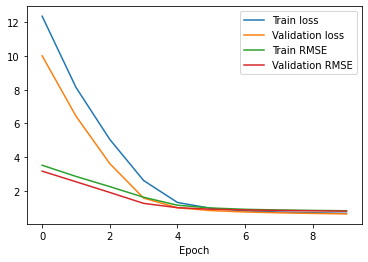

In [8]:
plt.plot(thist, label='Train loss')
plt.plot(vhist, label='Validation loss')
plt.plot(t_rmse_hist, label='Train RMSE')
plt.plot(v_rmse_hist, label='Validation RMSE')

plt.xlabel('Epoch')
plt.legend()

plt.show()

In [9]:
ar_dataloader = make_dataloader(df, IAutoRecRatingDataset, n_users, n_items)
autorec = AutoRec(n_users).to(device)
ar_trainer = AutoRecTrainer(ar_dataloader, ar_dataloader, autorec, device, n_epochs=10)
thist, vhist, t_rmse_hist, v_rmse_hist = ar_trainer.train()
IAutoRecEvaluator().evaluate(autorec, ar_dataloader, device, cutoff=5)

100%|██████████| 50/50 [00:00<00:00, 116.38it/s]


{'RMSE': 0.8716124099064991,
 'MRR@5': 0.7480365296803649,
 'MRR@10': 0.7538057186344853,
 'nDCG@5': 0.8473263309376324,
 'nDCG@10': 0.8444688102559693}

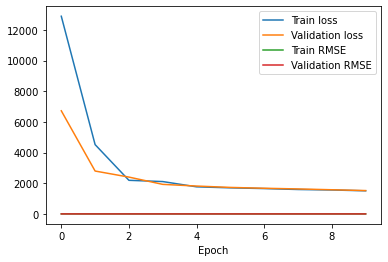

In [12]:
plt.plot(thist, label='Train loss')
plt.plot(vhist, label='Validation loss')
plt.plot(t_rmse_hist, label='Train RMSE')
plt.plot(v_rmse_hist, label='Validation RMSE')

plt.xlabel('Epoch')
plt.legend()

plt.show()

100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


{'RMSE': 1.0117753498884783,
 'MRR@5': 0.5996031746031747,
 'MRR@10': 0.6079648526077098,
 'nDCG@5': 0.9001461704147824,
 'nDCG@10': 0.894371178712001}

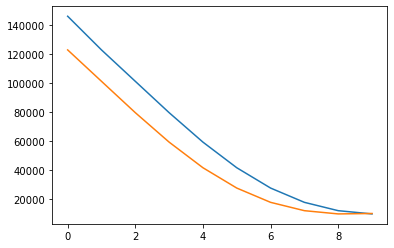

In [63]:
uar_dataloader = make_dataloader(df, UAutoRecRatingDataset, n_users, n_items)
uautorec = AutoRec(n_items).to(device)
uar_trainer = AutoRecTrainer(uar_dataloader, uar_dataloader, uautorec, device, n_epochs=10)
thist, vhist = uar_trainer.train()
plt.plot(thist)
plt.plot(vhist)
UAutoRecEvaluator().evaluate(uautorec, uar_dataloader, device, cutoff=5)

In [5]:
foo_dataloader = make_dataloader(df, AutoRecRatingDataset, n_users, n_items)

In [6]:
autorec = IAutoRec(n_users, n_items).to(device)

NameError: name 'IAutoRec' is not defined

In [137]:
hist, _ = train_autorec(foo_dataloader, foo_dataloader,
                        autorec, device, n_epochs=10)

Validation: 100%|██████████| 50/50 [00:00<00:00, 124.37it/s, Loss=0.0169]


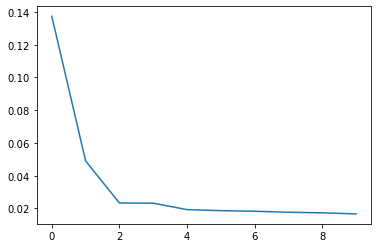

In [138]:
plt.plot(hist)
plt.show()

In [139]:
foo_r, foo_mask = next(iter(foo_dataloader))
foo_r = foo_r.to(device, dtype=torch.float32)
foo_mask = foo_mask.to(device, dtype=torch.float32)

In [140]:
foo_pred = autorec(foo_r)

In [141]:
foo_pred

tensor([[3.8445, 1.8666, 3.0496,  ..., 3.0846, 2.3326, 3.4344],
        [4.0329, 2.0071, 2.7060,  ..., 2.8871, 2.5593, 3.4574],
        [4.1090, 2.1479, 2.7566,  ..., 3.0703, 2.7035, 3.6072],
        ...,
        [4.9139, 2.3493, 3.8385,  ..., 3.9001, 2.9223, 4.3366],
        [4.5242, 2.2964, 3.6311,  ..., 3.7846, 2.7076, 4.1337],
        [5.0511, 2.3800, 3.8413,  ..., 4.1201, 2.9440, 4.3636]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [144]:
foo_actual_np = foo_r.detach().cpu().numpy()[foo_mask.detach().cpu().numpy().astype(bool)]
foo_pred_np = foo_pred.detach().cpu().numpy()[foo_mask.detach().cpu().numpy().astype(bool)]

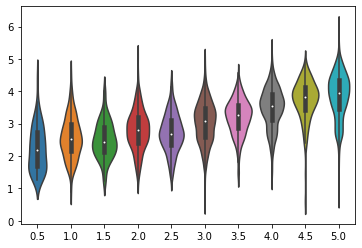

In [146]:
sns.violinplot(x=foo_actual_np, y=foo_pred_np)
plt.show()

[I 2022-01-14 09:43:14,171] A new study created in memory with name: no-name-3da6fb42-33b1-4ae5-a420-1e578e1ad6d3


Validation: 100%|██████████| 16/16 [00:00<00:00, 114.65it/s, Loss=1.02]


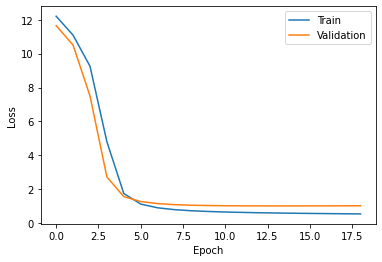

100%|██████████| 20/20 [00:00<00:00, 158.72it/s]


{'RMSE': 0.9944978041493148,
 'MRR@5': 0.5376940639269403,
 'MRR@10': 0.5434469449880405,
 'nDCG@5': 0.9284822407195891,
 'nDCG@10': 0.9404425253126586}

In [58]:
train_dataloader_gmf = make_dataloader(train_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
validation_dataloader_gmf = make_dataloader(validation_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
gmf = GMF(n_users, n_items).to(device)
gmf_trainer = GMFTrainer(train_dataloader_gmf, validation_dataloader_gmf,
                            gmf, device, lr=0.0027, embedding_dimensions=25, reg=1e-7,
                            n_epochs=40)
thist, vhist = gmf_trainer.train()
plt.plot(thist, label='Train')
plt.plot(vhist, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_dataloader_gmf = make_dataloader(test_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
GMFEvaluator().evaluate(gmf, test_dataloader_gmf, device, cutoff=5)

Validation: 100%|██████████| 76/76 [00:11<00:00,  6.84it/s, Loss=0.863]


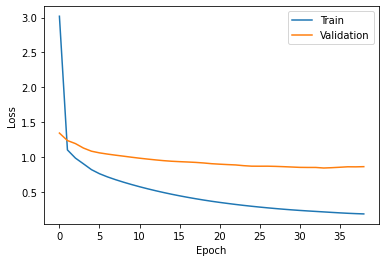

100%|██████████| 76/76 [00:32<00:00,  2.36it/s]


{'RMSE': 0.9079645278764537,
 'MRR@5': 0.5067320823186594,
 'MRR@10': 0.5153886058075884,
 'nDCG@5': 0.884989923341755,
 'nDCG@10': 0.8988263391056777}

In [18]:
train_dataloader = make_dataloader(train_df, IAutoRecRatingDataset, n_users, n_items)
validation_dataloader = make_dataloader(validation_df, IAutoRecRatingDataset, n_users, n_items)
autorec = AutoRec(n_users).to(device)
ar_trainer = AutoRecTrainer(train_dataloader, validation_dataloader,
                            autorec, device, lr=3 * 1e-4, reg_lambda=0,
                            n_epochs=40)
thist, vhist = ar_trainer.train()
plt.plot(thist, label='Train')
plt.plot(vhist, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_dataloader = make_dataloader(test_df, IAutoRecRatingDataset, n_users, n_items)
IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)

Validation: 100%|██████████| 50/50 [00:00<00:00, 132.41it/s, Loss=0.965]


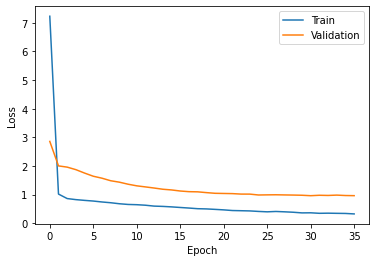

100%|██████████| 50/50 [00:00<00:00, 115.37it/s]


{'RMSE': 0.9163955771610593,
 'MRR@5': 0.5633105022831044,
 'MRR@10': 0.5688970428353987,
 'nDCG@5': 0.8425781172770767,
 'nDCG@10': 0.8614421099806714}

In [63]:
train_dataloader_v2 = make_weighted_dataloader(train_df, IAutoRecRatingDataset, n_users, n_items)
validation_dataloader_v2 = make_dataloader(validation_df, IAutoRecRatingDataset, n_users, n_items)
autorecv2 = AutoRecV2(n_users, p=.65).to(device)
ar_trainer_v2 = AutoRecTrainer(train_dataloader_v2, validation_dataloader_v2,
                            autorecv2, device, lr=2 * 1e-4, reg_lambda=0, 
                            n_epochs=40)
thist_v2, vhist_v2 = ar_trainer_v2.train()
plt.plot(thist_v2, label='Train')
plt.plot(vhist_v2, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_dataloader_v2 = make_dataloader(test_df, IAutoRecRatingDataset, n_users, n_items)
IAutoRecEvaluator().evaluate(autorecv2, test_dataloader_v2, device, cutoff=5)

In [19]:
train_dataloader = make_dataloader(train_df, IAutoRecRatingDataset, n_users, n_items)
validation_dataloader = make_dataloader(validation_df, IAutoRecRatingDataset, n_users, n_items)
autorec = AutoRec(n_users).to(device)
ar_trainer = AutoRecTrainer(train_dataloader, validation_dataloader,
                            autorec, device, lr=3 * 1e-4, reg_lambda=0,
                            n_epochs=40)
thist, vhist = ar_trainer.train()
plt.plot(thist, label='Train')
plt.plot(vhist, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

test_dataloader = make_dataloader(test_df, IAutoRecRatingDataset, n_users, n_items)
IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)

Train epoch 2/40:  68%|██████▊   | 52/76 [00:08<00:04,  5.79it/s, Loss=1.18]


KeyboardInterrupt: 

In [ ]:
gmf_ml_hyperparams = (
    hyperparameter_tune('GMF', {
        'embedding_dimensions': (int, (4, 32), False),
        'embeddings_init_std': (float, (.01, 1), True),
        'lr': (float, (5 * 1e-6, 1e-1), True),
        'reg': (float, (1e-8, 1e-4), True),
        'patience': (int, (0, 10), False),        
    }, 1024, train_val_df, n_trials=18, n_epochs=20)
)

print(gmf_ml_hyperparams)
with open('hyperparams/gmf.json', 'w') as f:
    json.dump(gmf_ml_hyperparams, f, indent=4)

[I 2022-01-15 11:09:18,391] A new study created in memory with name: no-name-e6c747a6-eb69-4cf6-a856-f36e5b424e81


In [14]:
test_df.shape

(20000, 3)

In [7]:
iautorec_ml_hyperparams

{'hidden_size': 676,
 'reg_lambda': 1.2164602606939368,
 'lr': 0.0008535395703466191,
 'reg': 6.530267997250569e-06,
 'init_std': 0.037982875733986815}

In [66]:
uautorec_ml_hyperparams = (
    hyperparameter_tune('UAutoRec', {
        'hidden_size': (int, (16, 1024), False),
        'reg_lambda': (float, (1e-3, 1e3), True),
        'lr': (float, (5 * 1e-6, 1e-1), True),
        'reg': (float, (1e-8, 1e-4), True),
        'patience': (int, (0, 10), False),        
    }, 64, train_val_df, n_trials=5, n_epochs=20)
)

print(uautorec_ml_hyperparams)

[I 2022-01-15 11:00:25,419] A new study created in memory with name: no-name-846fbd90-b742-44ca-a447-213b7ef46dbe
[I 2022-01-15 11:00:34,356] Trial 0 finished with value: 24491.8134765625 and parameters: {'hidden_size': 507, 'reg_lambda': 144.17557368559582, 'lr': 0.04702282999203399, 'reg': 2.5080881235430423e-07, 'patience': 6}. Best is trial 0 with value: 24491.8134765625.
[I 2022-01-15 11:00:43,410] Trial 1 finished with value: 4949.94970703125 and parameters: {'hidden_size': 658, 'reg_lambda': 0.025953238886673537, 'lr': 0.00010310297703070083, 'reg': 1.3923119336594042e-05, 'patience': 6}. Best is trial 1 with value: 4949.94970703125.
[I 2022-01-15 11:00:52,311] Trial 2 finished with value: 1981.8033752441406 and parameters: {'hidden_size': 103, 'reg_lambda': 0.008332093722459247, 'lr': 0.013610355844002194, 'reg': 7.2771730033996284e-06, 'patience': 0}. Best is trial 2 with value: 1981.8033752441406.
[I 2022-01-15 11:01:01,537] Trial 3 finished with value: 10622.00830078125 and 

{'hidden_size': 103, 'reg_lambda': 0.008332093722459247, 'lr': 0.013610355844002194, 'reg': 7.2771730033996284e-06, 'patience': 0}


In [6]:
iautorec_ml_hyperparams = json.load(open('hyperparams/iautorec.json'))
iautorec_ml_hyperparams

{'hidden_size': 563,
 'reg_lambda': 0.0025291267465588517,
 'lr': 0.0002167270844796448,
 'reg': 1.6660866037918844e-06,
 'init_std': 0.02123501205382139}

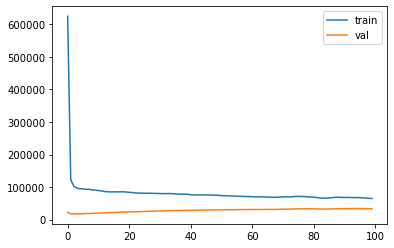

In [9]:
plt.plot(thist, label='train')
plt.plot(vhist, label='val')
plt.legend()
plt.show()

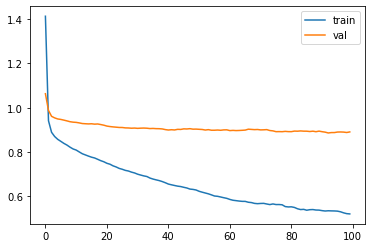

In [8]:
plt.plot(thist_rme, label='train')
plt.plot(vhist_rme, label='val')
plt.legend()
plt.show()

In [21]:
autorec = torch.load('trained_models/iautorec.pt')
test_dataloader = make_dataloader(test_df, IAutoRecRatingDataset, n_users, n_items, batch_size=128)
IAutoRecEvaluator().evaluate(autorec, test_dataloader, device, cutoff=5)

100%|██████████| 76/76 [00:34<00:00,  2.21it/s]


{'RMSE': 0.8763149951336634,
 'MRR@5': 0.4657857358277439,
 'MRR@10': 0.47093709999540145,
 'nDCG@5': 0.9032257528773334,
 'nDCG@10': 0.9156545852907158}

In [6]:
# gmf = GMF(n_users, n_items).to(device)

In [7]:
# train_hist, validation_hist = train(train_dataloader, validation_dataloader, gmf, device, n_epochs=10)

Validation: 100%|██████████| 1562/1562 [00:10<00:00, 148.24it/s, Loss=0.597]


In [9]:
test_dataloader = make_dataloader(test_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
evaluate(gmf, test_dataloader, device, cutoff=5)

100%|██████████| 1953/1953 [00:08<00:00, 236.43it/s]


KeyboardInterrupt: 

In [73]:
test_df

,user_id,item_id,rating
7974210,55946,798,5.0
9325312,65419,358,4.0
166451,1266,992,4.0
2151717,15282,2472,3.0
231852,1752,415,4.0
...,...,...,...
744161,5496,1350,2.0
6832819,47717,2576,3.0
5073521,35426,1009,4.0
5142577,35907,94,5.0


In [74]:
gmf = GMF(n_users, n_items).to(device)
gmf_ml_hyperparams

{'embedding_dimensions': 25,
 'embeddings_init_std': 0.02227642494256414,
 'lr': 0.0002794211931832123,
 'reg': 5.763941594458828e-07,
 'patience': 1}

In [ ]:
train_dataloader = make_dataloader(train_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
validation_dataloader = make_dataloader(validation_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
gmf = GMF(n_users, n_items, **gmf_ml_hyperparams).to(device)
gmf_trainer = GMFTrainer(train_dataloader, validation_dataloader, gmf, device, n_epochs=20, verbose=True, **gmf_ml_hyperparams)
thist, vhist = gmf_trainer.train()

Train epoch 1/20:  66%|██████▌   | 4397/6638 [00:31<00:17, 131.65it/s, Loss=5.57]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa099f8e830><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa099f8e830>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa099f8e830>
Traceback (most recent call last):
  File "/home/jupyter-itay/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
      File "/home/jupyter-itay/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    
self._shutdown_workers()
  File "/home/jupyter-itay/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
      File "/home/jupyter-itay/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()    i

In [86]:
test_dataloader = make_dataloader(test_df, GMFRatingDataset, n_users, n_items, batch_size=1024)
GMFEvaluator().evaluate(gmf, test_dataloader, device, cutoff=5)

100%|██████████| 1953/1953 [00:07<00:00, 262.58it/s]


{'RMSE': 0.8176818614720773,
 'MRR@5': 0.5611587849614849,
 'MRR@10': 0.5676412859409946,
 'nDCG@5': 0.9305990399660979,
 'nDCG@10': 0.944717420269196}

Improvement ideas:

* Bias per item (for IAutoRec)
* Explicit rating availability vector
* Deeper?
* Dropout on input thingy
* Turn to classification problem
* Oversample items with lots of ratings